# DMD

## Setup

In [31]:
import numpy as np
import matplotlib.pyplot as plt

Primeiro, definimos algumas funções para teste.

Essas funções tem parte imaginária para demonstrar a capacidade do DMD de lidar com problemas complexos.

In [32]:
x = np.linspace( -10, 10, 200)
t = np.linspace(0, 4 * np.pi , 61)
dt = t[1] - t[0]

In [33]:
S, T = np.meshgrid(x, t)

In [34]:
# Criando os modos para testar o potencial de captura do DMD
# Essa primeira função é puramente espacial e real
X1 = 0.8 * np.sin(S) * (1 + 0 * T)
# Essa segunda função, por sua vez, é espaço-temporal e complexa
X2 = 1.0 / np.cosh(S + 3) * np.exp(2.3j * T)
# Nosso sinal de teste é a soma dessas duas funções
# Testaremos então a capacidade do DMD de capturar as duas funções
X_base = X1 + X2

In [35]:
X_base

array([[ 0.43704065+0.00000000e+00j,  0.36768779+0.00000000e+00j,
         0.29466486+0.00000000e+00j, ..., -0.29242955+0.00000000e+00j,
        -0.36566621+0.00000000e+00j, -0.43521237+0.00000000e+00j],
       [ 0.43683311+8.44941896e-04j,  0.36745831+9.34274404e-04j,
         0.29441112+1.03305166e-03j, ..., -0.29243018+2.56068223e-06j,
        -0.36566678+2.31583707e-06j, -0.43521288+2.09440330e-06j],
       [ 0.43625773+1.49758106e-03j,  0.3668221 +1.65591464e-03j,
         0.29370764+1.83098815e-03j, ..., -0.29243192+4.53857152e-06j,
        -0.36566835+4.10460620e-06j, -0.43521431+3.71213541e-06j],
       ...,
       [ 0.43349457+5.99774630e-04j,  0.36376679+6.63186531e-04j,
         0.29032932+7.33302703e-04j, ..., -0.29244029+1.81767793e-06j,
        -0.36567593+1.64387673e-06j, -0.43522116+1.48669391e-06j],
       [ 0.43341269-2.66420737e-04j,  0.36367626-2.94588393e-04j,
         0.29022921-3.25734095e-04j, ..., -0.29244054-8.07415102e-07j,
        -0.36567615-7.30212363e-07j

In [36]:
X_base.T.shape

(200, 61)

São $61$ snapshots de dimensão $200$.

Antes de prosseguirmos, vamos visualizar nossos modos.

## Visualizações (pré-DMD)

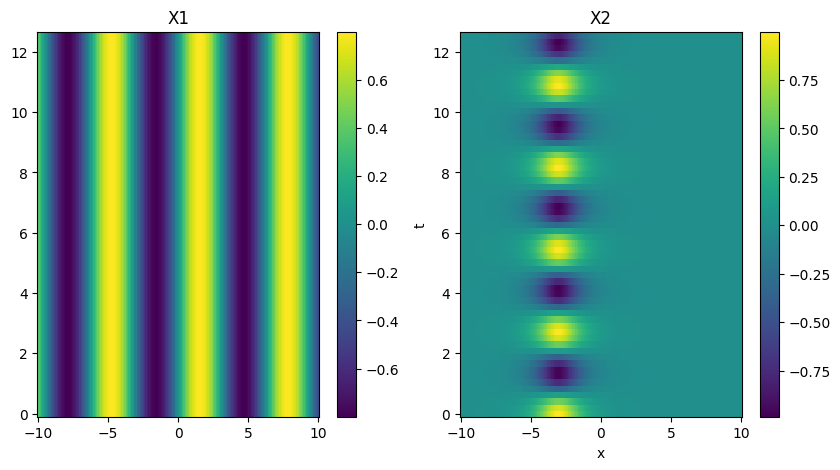

In [37]:
# Plot X1
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pcolor(S, T, X1)
plt.colorbar()
plt.title('X1')
# Plot X2
plt.subplot(1, 2, 2)
plt.pcolor(S, T, X2.real)
plt.colorbar()
plt.title('X2')
# Show axis t
plt.xlabel('x')
plt.ylabel('t')
plt.show()

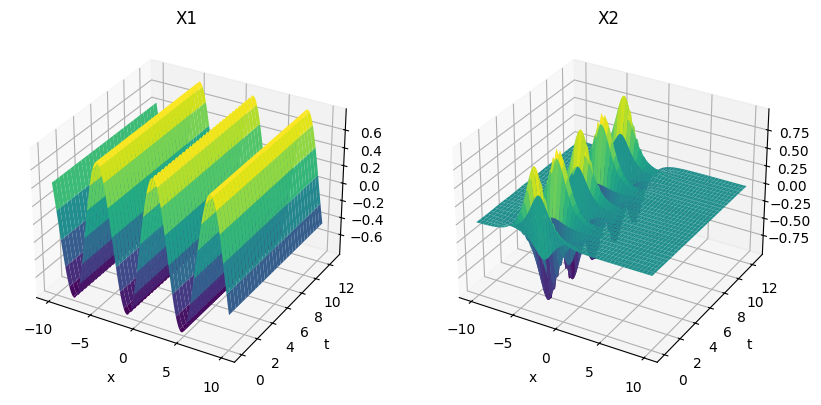

In [38]:
# Visualizando tridimensionalmente
# X1, X2 e X_base
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(S, T, X1, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('X1')
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(S, T, X2.real, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('X2')
plt.show()

In [71]:
X_base = np.zeros((2, 101))
X_base[0, :] = np.sin(np.linspace(0, 2 * np.pi, 101))
X_base[1, :] = np.cos(np.linspace(0, 2 * np.pi, 101))
t = np.linspace(0, 2 * np.pi, 101)
t.shape

(101,)

In [72]:
X_base.shape

(2, 101)

## Aplicando o DMD

In [73]:
# Separando X em X e X' (Y)
X = X_base[:, :-1]
Y = X_base[:, 1:]
print(X.shape, Y.shape)

(2, 100) (2, 100)


Antes mesmo de começar já temos uma peculiaridade em relação ao POD: vamos truncar os resulados do SVD baseado no posto aproximado $r$ da matriz $X$.

Em casos menos experimentais, seria correto aplicar um algoritmo para calcular este posto aproximado.
Contudo, como é sabido que ele guiará a quantidade de modos que o DMD identificará, vamos já estabelecer $r = 2$.

**1º passo**

Fazendo o SVD da matriz de snapshots. Aqui não fazemos o SVD completo. Como sugere o algoritmo, fazemos o SVD aproximado,
obtendo $U$, $\Sigma$ e $V^*$.

Depois, truncamos essas matrizes em $r$, obtendo $\tilde{U}$, $\tilde{\Sigma}$ e $\tilde{V^T}$.

Isto é,
$$
X \approx \tilde{U} \tilde{\Sigma} \tilde{V^T} \text{.}
$$

In [74]:
rank = 2

In [75]:
U, s, V = np.linalg.svd(X, full_matrices=False)
V = V.conj().T
U = U[:, :rank]
V = V[:, :rank]
s = s[:rank]

**2º passo**

Agora buscaremos a matriz $A$ que melhor avança o sistema no tempo. Ou seja, essa matriz é o operador linear $X \rightarrow X'$ que buscamos.

Ou seja, a otimização de $A$ é definida por (Brunton)
$$
A = \argmin_A ||X' - AX||_F
$$
(F é a norma de Frobenius), o que nos leva imediatamente a
$$
A = X'X^\dagger \text{,}
$$
onde $\dagger$ denota a pseudo-inversa.

Contudo, computar essa pseudo-inversa, bem como a multiplicação de matrizes pode ser extremamente custoso computacionalmente em casos de alta dimensionalidade.
Como estes casos são, justamente, onde o DMD "brilha", não é usual que isso seja feito. **(mostrar o que acontece quando se tenta fazer isso)**

Logo, podemos obter $A$ a partir do SVD já feito
$$
A = X' \tilde{V} \tilde{\Sigma}^{-1} \tilde{U}^T \text{,}
$$
contudo, como nos interessa apenas os $r$ primeiros autovalores e autovetores de $A$,
podemos aproveitar para projetar $A$ em $U$, gerando $\tilde{A}$:
$$
\tilde{A} = \tilde{U}^TA\tilde{U} = \tilde{U}^T X' \tilde{V} \tilde{\Sigma}^{-1} \tilde{U}^T\tilde{U}\text{,}
$$
como sabe-se, pelas proprieadades do POD / SVD que $\tilde{U}^T\tilde{U} = I$,
$$
\tilde{A} = \tilde{U}^T X' \tilde{V} \tilde{\Sigma}^{-1}\text{.}
$$

In [76]:
atilde = np.linalg.multi_dot([U.T.conj(), Y, V]) * np.reciprocal(s)
# making atilde regular A instead
# A = X' * V * S^-1 * U^T
#atilde = np.linalg.multi_dot([Y, V, np.diag(np.reciprocal(s)), U.T.conj()])
atilde.shape

(2, 2)

**3º passo**

Agora, obteremos os autovalores e autovalores que, se tudo der certo, ditam a dinâmica do sistema.

Faz-se então a decomposição espectral de $\tilde{A}$.
$$
\tilde{A}W = W\Lambda
\\
\tilde{A} = W\Lambda W^{-1}
$$
(usando ``numpy`` pra isso mesmo)

In [77]:
Lambda, W = np.linalg.eig(atilde)
print(Lambda.shape, W.shape)

(2,) (2, 2)


**4º passo**

Finalmente, obtemos os modos do DMD dispostos na matriz $\Phi$ usando os autovetores em $W$ e $X'$.
Aqui uso o modo original de computar $\Phi$, do paper de Schmid.
Tive resultados incosistentes com o método em Brunton.
$$
\Phi = \tilde{U}W
$$

In [78]:
#Phi = U.dot(W)
Phi = np.linalg.multi_dot([Y, V, np.diag(np.reciprocal(s)), W])
Phi.shape

(2, 2)

**5º passo**

Calculando as amplitudes.

In [79]:
b = np.linalg.lstsq(Phi, X.T[0], rcond=None)[0]

## Resultados

### Reconstrução

$$
x(t) = \sum_{j=1}^r \phi_j e^{\omega_j^t} b_j = \Phi \exp(\Omega t) b
$$

![](dmd_reconstrucao.png)

In [80]:
# Vetor omega
omega = np.log(Lambda) / dt
omega

array([1.04776085e-15+0.3j, 1.04776085e-15-0.3j])

In [81]:
# Matriz T_omega
T_omega = np.zeros((rank, 101), dtype='complex')
T_omega.shape

(2, 101)

In [82]:
# each element is e^{omega_r t_m}
for i in range(rank):
    for j in range(101):
        T_omega[i, j] = np.exp(omega[i] * t[j])

In [83]:
X_dmd = Phi @ np.diag(b) @ T_omega
X_dmd.shape

(2, 101)

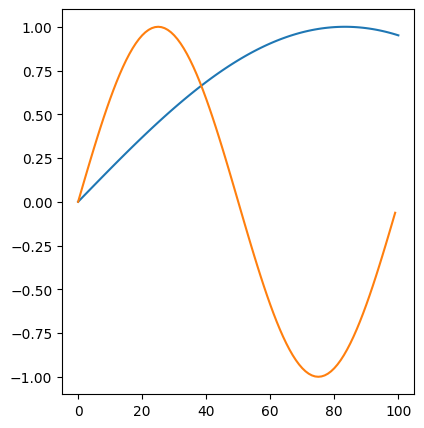

In [89]:
# plot X_dmd[0] against X[0]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(X_dmd[0].real)
plt.plot(X[0].real)

In [85]:
i_mode = 0

In [86]:
# reconstruindo apenas o primeiro modo
X_mode = Phi[:, i_mode] * b[i_mode]
X_mode = X_mode.reshape((X_mode.shape[0], 1))
X_mode = X_mode @ T_omega[i_mode, :].reshape((1, T_omega.shape[1]))
X_mode.shape

(2, 101)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (61, 200) and arg 2 with shape (101, 2).

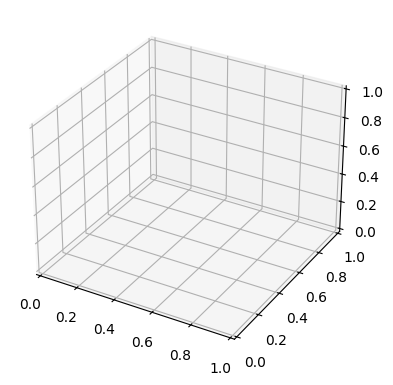

In [87]:
# plot X_mode, 3D
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(S, T, X_mode.T.real, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Modo 1')
# Plot X1
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(S, T, X1, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('X1')
plt.show()

In [ ]:
i_mode = 1

In [ ]:
# reconstruindo apenas o segundo modo
X_mode = Phi[:, i_mode] * b[i_mode]
X_mode = X_mode.reshape((X_mode.shape[0], 1))
X_mode = X_mode @ T_omega[i_mode, :].reshape((1, T_omega.shape[1]))
X_mode.shape

(200, 61)

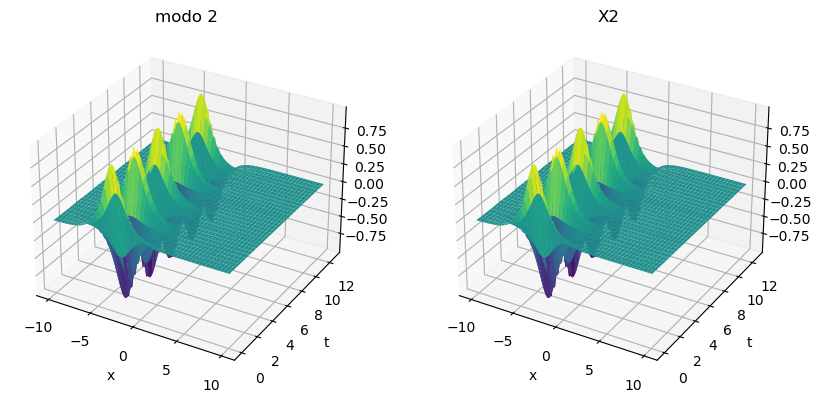

In [ ]:
# plot X_mode, 3D
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(S, T, X_mode.T.real, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Modo 2')
# Plot X2
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(S, T, X2.real, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('X2')
plt.show()

### Predição

Como visto, a matriz $A$ é o operador que avança a dinâmica no tempo.

De Brunton:
$$
A \Phi = \Phi \Lambda
\\
A = \Phi \Lambda \Phi^{\dagger}
$$

In [ ]:
from scipy.linalg import pinv

In [ ]:
eigs = np.diag(np.atleast_1d(Lambda))
eigs

array([[1.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.88620358+0.46329604j]])

In [ ]:
# Iterando 50 previsões a partir de X[:, 0]
predictions = [X[:, 0].real]
for i in range(60):
    Y = np.linalg.multi_dot([Phi, eigs, pinv(Phi), predictions[-1]])
    predictions.append(Y.real)
predictions = np.array(predictions)

In [ ]:
S.shape

(61, 200)

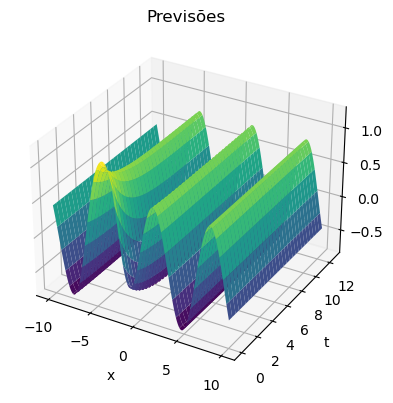

In [ ]:
# plot predictions, 3D
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(S, T, predictions, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Previsões')
plt.show()

O "brilho" do DMD mesmo é a redução de dimensionalidade.